In [1]:
import pandas as pd
import numpy as np
import pickle

%run libreria.py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import utm
import pandas as pd
import math
from matplotlib.pyplot import figure
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pymysql

def get_connection():
    return pymysql.connect(host='ec2-18-222-185-142.us-east-2.compute.amazonaws.com',
                             user='root',
                             password='password',
                             db='dbname',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
        
    
def final_plot_old(df_pares_abejas, dic_curva=None):
    f=figure(facecolor="white", edgecolor="black")
    f.set_facecolor('white')
    ax = f.add_subplot(1, 1, 1) # nrows, ncols, index
    ax.set_facecolor("white")
    ma1=5
    ma2=5
    if dic_curva==None:
        dic_curva={}

        for k in range(0, 101, 10):
            print(k, end="   \r")
            cropped=df_pares_abejas[(df_pares_abejas.Similitud_genetica_4>= (k-ma1)/100.0) & 
                                     (df_pares_abejas.Similitud_genetica_4< (k+ma1)/100.0)]
            leni=len(cropped)
            if leni>0:
                xs=[]
                ys=[]
                for s in range(0, 50):
                    #cropped["d2"]=[i+random.normalvariate(0,1) for i in cropped["Distancia"]]
                    l1=len(cropped[(cropped.Distancia < (s))])/leni
                    xs.append(l1)
                    ys.append(s)
                color=(k)/(100)
                c1="#1c92d2"
                c2="#f2fcfe"
                color=gradient(c1, c2, color)
                plt.plot(ys, xs, c=color, label="p ["+str(np.max([(k-ma1)/100.0, 0.0]))+", "+str(np.min([(k+ma1)/100.0, 1])) +")")
                dic_curva[k]=[ys, xs]
    else:
         for k in range(0, 101, 10):
            color=(k)/(100)
            c1="#1c92d2"
            c2="#f2fcfe"
            color=gradient(c1, c2, color)
            xs=dic_curva[k][1]
            ys=dic_curva[k][0]
            plt.plot(ys, xs, c=color, label="p ["+str(np.max([(k-ma1)/100.0, 0.0]))+", "+str(np.min([(k+ma1)/100.0, 1])) +")")
    plt.ylim([0,1])
    plt.legend()
    ax.set_xlabel("Kms between the sites where each pair now collected")
    ax.set_ylabel("Proportion of pairs")
    f.savefig("final_frequencies.pdf")
    plt.show()
    return dic_curva
            
    
    
def result_pmeth(name, dicton_final, category, tasks_sql, return_means=False, print_sol=True):
    
    all_tasks=[r["task_id"] for r in tasks_sql]
    
    tasks_df=pd.DataFrame(tasks_sql)
    tasks_df["N_mam"]=[eval(aa)["N_mam"] for aa in tasks_df["task_params"]]
    fams=list(set(tasks_df["N_mam"]))


    
    tasks_new={"all":{}, "urban":{}, "rural":{}}

    for kk in fams:
        tasks_new["all"][kk]=[]
        tasks_new["urban"][kk]=[]
        tasks_new["rural"][kk]=[]

    for k in tasks_sql:
        d2=eval(k["task_params"])
        if d2["urban"] & (not d2["rural"]):
            tasks_new["urban"][d2["N_mam"]].append(k["task_id"])
        if (not d2["urban"]) & (d2["rural"]):
            tasks_new["rural"][d2["N_mam"]].append(k["task_id"])
        if (d2["urban"]) & (d2["rural"]):
            tasks_new["all"][d2["N_mam"]].append(k["task_id"])


        
    connection=get_connection()

    with connection.cursor() as cursor:
        sql="delete from abejas_curvas2"
        cursor.execute(sql)
        sql="insert  into  abejas_curvas2 select distinct * from abejas_curvas where task_id in ("+", ".join([str(s) for s in all_tasks])+");"
        cursor.execute(sql)

    connection.commit()
    connection.close()

    connection=get_connection()
    with connection.cursor() as cursor:
        for kk in fams:
            print(kk)
            for k in range(0,101, 10):
                if k in dicton_final[category][kk]:
                    sql="update abejas_curvas2 set "
                    for i in range(50):



                        sql+="int_"+str(i)+"= int_"+str(i)+" - "+str(dicton_final[category][kk][k][1][i])


                        if i<=48:
                            sql+=", "
                    sql+=" where k="+str(k)+" and task_id in ("+", ".join([str(y) for y in tasks_new[category][kk]])+");"
                else:
                    print("Deleting k="+str(k))
                    sql="delete from abejas_curvas2  "
                    
                    sql+=" where k="+str(k)+" and task_id in ("+", ".join([str(y) for y in tasks_new[category][kk]])+");"
                cursor.execute(sql)
    connection.commit()
    connection.close()


    connection=get_connection()

    with connection.cursor() as cursor:
        sql="select * from abejas_curvas2"
        cursor.execute(sql)
        abejas_curvas_2=cursor.fetchall()
    connection.close()

    df_abejas_curvas_2=pd.DataFrame(abejas_curvas_2)

    for k in range(50):
        print(k, end="    \r")
        df_abejas_curvas_2["Int_"+str(k)+"_abs"]=abs(df_abejas_curvas_2["Int_"+str(k)])
        if k<49:
            df_abejas_curvas_2["chs_"+str(k)]=((df_abejas_curvas_2["Int_"+str(k)])*(df_abejas_curvas_2["Int_"+str(k+1)])<0)


    for k in range(50):
        print(k, end="    \r")
        if k==0:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=df_abejas_curvas_2["Int_"+str(k)+"_abs"]/2-(0.25)*df_abejas_curvas_2["chs_"+str(k)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]
        elif k<49:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=df_abejas_curvas_2["Int_"+str(k)+"_abs"]-(0.25)*df_abejas_curvas_2["chs_"+str(k)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]-(0.25)*df_abejas_curvas_2["chs_"+str(k-1)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]
        else:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=(df_abejas_curvas_2["Int_"+str(k)+"_abs"]/2)-(0.25)*df_abejas_curvas_2["chs_"+str(k-1)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]

    df_abejas_curvas_2["int_mean"]=df_abejas_curvas_2[["Int_"+str(j)+"_abs_adj" for j in range(50)]].mean(1)

    np.sum(np.isnan(df_abejas_curvas_2["int_mean"]))

    from scipy.stats.mstats import gmean

    df_abejas_curvas_2=df_abejas_curvas_2[df_abejas_curvas_2["k"]<105][["int_mean", "task_id"]].groupby("task_id").mean()

    df_abejas_curvas_2=df_abejas_curvas_2.join(pd.DataFrame(tasks_sql).set_index("task_id")[["task_params"]], how="inner")

    d2=1
    df_abejas_curvas_2["bootstrap"]=[eval(aa)["bootstrap"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["N_mam"]=[eval(aa)["N_mam"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["urban"]=[eval(aa)["urban"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["rural"]=[eval(aa)["rural"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["lambda"]=[eval(aa)["params"]["lambd"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["exp_mean"]=1/df_abejas_curvas_2["lambda"]

    if print_sol: f=plt.figure(figsize=(16,16))
    kleuren=["red", "brown","green", "cyan", "orange", "pink"]
    ii=0
    #nmams=[900]
    #kleuren=["green"]
    for uu in fams:
        print(uu)
        if category=="urban":
            cropp=df_abejas_curvas_2[(df_abejas_curvas_2.urban==True) & (df_abejas_curvas_2.rural==False) & (df_abejas_curvas_2.N_mam==uu)]
        if category=="rural":
            cropp=df_abejas_curvas_2[(df_abejas_curvas_2.urban==False) & (df_abejas_curvas_2.rural==True) & (df_abejas_curvas_2.N_mam==uu)]
        if category=="all":
            cropp=df_abejas_curvas_2[(df_abejas_curvas_2.urban==True) & (df_abejas_curvas_2.rural==True) & (df_abejas_curvas_2.N_mam==uu)]

        if print_sol:
            for boot in range(100):

                c2=cropp[cropp["bootstrap"]==boot]
                #if boot==0: plt.plot(c2["exp_mean"], c2["int_mean"], color=kleuren[ii], alpha=0.06, label=str(uu))
                plt.plot(c2["exp_mean"], c2["int_mean"], color=kleuren[ii], alpha=0.06, label="")

        #plt.show()
        c2=cropp.groupby(["exp_mean"]).mean().reset_index()
        if print_sol: 
            plt.plot(c2["exp_mean"], c2["int_mean"], color=kleuren[ii], linewidth=6, label=str(uu)+" families")
            ll=list(c2["int_mean"])
            mini=np.min(ll)
            indi=list(c2["exp_mean"])[ll.index(mini)]
            plt.scatter([indi, indi, indi], [0.007+ii/2000, 0.006+ii/2000, 0.005+ii/2000], color=kleuren[ii])


        ii+=1
        #plt.show()

    if print_sol:
        plt.xlabel("")
        plt.legend(fontsize=20)
        plt.xticks([i for i in range(6)], [str(i)+"" for i in range(6)], size=20)
        plt.yticks([i/1000 for i in range(5, 90, 10)], size=20)
        plt.xlabel("\n Dispersal distribution mean (km)", size=24)
        plt.ylabel("$\Delta$ geometric mean area of cumulative distribution plot \n", size=24)
        plt.xlim([0,5.5])
        lima=plt.ylim()[1]
        plt.ylim([0,lima])
        plt.show()  
        f.savefig(name+"_peko.pdf")
    if return_means: return (list(c2["exp_mean"]), list(c2["int_mean"]))

    




def make_bias_test1(tidson, tasks_new, category, nfam, name):
    
    connection=get_connection()

    
    with connection.cursor() as cursor:
        sql="select distinct * from abejas_curvas where task_id in ("+", ".join([str(placebo) for placebo in tidson])+")"
        cursor.execute(sql)
        res_plac=cursor.fetchall()
    connection.commit()
    connection.close()

    df_plac=pd.DataFrame(res_plac)
    df_plac=df_plac.groupby(["k", "task_id"]).first().reset_index()
    
    maxis=[]
    a=0
    plts={}

    f=plt.figure(figsize=(16,16))
    #300 - 1.325
    
    for placebo in tidson:
        
        dicton_final={category:{nfam:{}}}
        
        new_dic_curva={}
        if len(df_plac[df_plac.task_id==placebo])>9:
            for s in df_plac[df_plac.task_id==placebo].iterrows():
                new_dic_curva[int(s[1]["k"])]=[[ints for ints in range(50)], [s[1]["Int_"+str(ints)] for ints in range(50)]]

            dicton_final[category][nfam]= new_dic_curva


            plts[a]=(result_pmeth("_", dicton_final, category, tasks_new, return_means=True, print_sol=False))
            print(a/len(tidson), end="      \r")
            a+=1
    a=0
    
    plt.figure(figsize=(14, 14))
    forhist=[]
    for p in plts:
        means, ys= plts[p]
        maxii=means[ys.index(np.min(ys))]
        plt.plot(means, ys, color="red", linewidth=6, label=str(uu)+" families", alpha=0.1)
        plt.scatter([maxii], [0.005], s=100, color="red", alpha=0.05)
        forhist.append(maxii)

    plt.xlabel("")
    plt.xticks([i for i in range(6)], [str(i)+" km" for i in range(6)],  size=15)
    plt.yticks([i/1000 for i in range(5, 90, 10)],   size=15)
    plt.xlabel("\n Distribution mean",  size=20)
    plt.ylabel("Avg. difference each simulation v. R-1 \n", size=20)
    plt.title("Difference between each replicate ($\Theta=1.85$) with the rest \n Circle shows all estimated ${\Theta}_r $")


    plt.xlim([0.5,5])
    #plt.ylim([0,0.03])

    plt.savefig("placebo_cline_"+name+".pdf")

    plt.show()
    
    
    plt.figure(figsize=(8,8))
    plt.hist(forhist, color="red", edgecolor="white")
    plt.title("Frequency of best $\Theta_r$ when comparing \n each replicate with $\Theta=3.025$ \n with R-1")
    plt.ylabel("Frequency")
    plt.xlabel("Mean dispersal estimated")
    plt.savefig("hist_cline_decline_"+name+".pdf")
    plt.xlim([0,5])
    plt.show()
    
    print("Mean :"+str(np.mean(forhist)))
    print("Std :"+str(np.std(forhist)))












Bad key "text.kerning_factor" on line 4 in
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [76]:
def result_pmeth_2(name, dicton_final, category, tasks_sql_dicton, return_means=False, print_sol=True):
    
    tasks_sql=[]
    sptasks={}
    for key in tasks_sql_dicton:
        tasks_sql+=tasks_sql_dicton[key]
        sptasks[key]=[r["task_id"] for r in tasks_sql_dicton[key]]
    
    all_tasks=[r["task_id"] for r in tasks_sql]
    
    tasks_df=pd.DataFrame(tasks_sql)
    tasks_df["N_mam"]=[eval(aa)["N_mam"] for aa in tasks_df["task_params"]]
    fams=list(set(tasks_df["N_mam"]))


    
    tasks_new={"all":{}, "urban":{}, "rural":{}}

    for kk in fams:
        tasks_new["all"][kk]=[]
        tasks_new["urban"][kk]=[]
        tasks_new["rural"][kk]=[]

    for k in tasks_sql:
        d2=eval(k["task_params"])
        if d2["urban"] & (not d2["rural"]):
            tasks_new["urban"][d2["N_mam"]].append(k["task_id"])
        if (not d2["urban"]) & (d2["rural"]):
            tasks_new["rural"][d2["N_mam"]].append(k["task_id"])
        if (d2["urban"]) & (d2["rural"]):
            tasks_new["all"][d2["N_mam"]].append(k["task_id"])


        
    connection=get_connection()

    with connection.cursor() as cursor:
        sql="delete from abejas_curvas2"
        cursor.execute(sql)
        sql="insert  into  abejas_curvas2 select distinct * from abejas_curvas where task_id in ("+", ".join([str(s) for s in all_tasks])+");"
        cursor.execute(sql)

    connection.commit()
    connection.close()

    connection=get_connection()
    with connection.cursor() as cursor:
        for kk in fams:
            print(kk)
            for k in range(0,101, 10):
                if k in dicton_final[category][kk]:
                    sql="update abejas_curvas2 set "
                    for i in range(50):



                        sql+="int_"+str(i)+"= int_"+str(i)+" - "+str(dicton_final[category][kk][k][1][i])


                        if i<=48:
                            sql+=", "
                    sql+=" where k="+str(k)+" and task_id in ("+", ".join([str(y) for y in tasks_new[category][kk]])+");"
                else:
                    print("Deleting k="+str(k))
                    sql="delete from abejas_curvas2  "
                    
                    sql+=" where k="+str(k)+" and task_id in ("+", ".join([str(y) for y in tasks_new[category][kk]])+");"
                cursor.execute(sql)
    connection.commit()
    connection.close()


    connection=get_connection()

    with connection.cursor() as cursor:
        sql="select * from abejas_curvas2"
        cursor.execute(sql)
        abejas_curvas_2=cursor.fetchall()
    connection.close()

    df_abejas_curvas_2=pd.DataFrame(abejas_curvas_2)

    for k in range(50):
        print(k, end="    \r")
        df_abejas_curvas_2["Int_"+str(k)+"_abs"]=abs(df_abejas_curvas_2["Int_"+str(k)])
        if k<49:
            df_abejas_curvas_2["chs_"+str(k)]=((df_abejas_curvas_2["Int_"+str(k)])*(df_abejas_curvas_2["Int_"+str(k+1)])<0)


    for k in range(50):
        print(k, end="    \r")
        if k==0:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=df_abejas_curvas_2["Int_"+str(k)+"_abs"]/2-(0.25)*df_abejas_curvas_2["chs_"+str(k)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]
        elif k<49:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=df_abejas_curvas_2["Int_"+str(k)+"_abs"]-(0.25)*df_abejas_curvas_2["chs_"+str(k)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]-(0.25)*df_abejas_curvas_2["chs_"+str(k-1)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]
        else:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=(df_abejas_curvas_2["Int_"+str(k)+"_abs"]/2)-(0.25)*df_abejas_curvas_2["chs_"+str(k-1)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]

    df_abejas_curvas_2["int_mean"]=df_abejas_curvas_2[["Int_"+str(j)+"_abs_adj" for j in range(50)]].mean(1)

    np.sum(np.isnan(df_abejas_curvas_2["int_mean"]))

    from scipy.stats.mstats import gmean

    df_abejas_curvas_2=df_abejas_curvas_2[df_abejas_curvas_2["k"]<105][["int_mean", "task_id"]].groupby("task_id").mean()

    df_abejas_curvas_2=df_abejas_curvas_2.join(pd.DataFrame(tasks_sql).set_index("task_id")[["task_params"]], how="inner")

    d2=1
    df_abejas_curvas_2["bootstrap"]=[eval(aa)["bootstrap"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["N_mam"]=[eval(aa)["N_mam"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["urban"]=[eval(aa)["urban"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["rural"]=[eval(aa)["rural"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["lambda"]=[eval(aa)["params"]["lambd"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["exp_mean"]=1/df_abejas_curvas_2["lambda"]

    if print_sol: f=plt.figure(figsize=(16,16))
    kleuren=["red", "brown","green", "cyan", "orange", "pink"]
    ii=0
    #nmams=[900]
    #kleuren=["green"]
    for key in tasks_sql_dicton:
        if category=="urban":
            cropp=df_abejas_curvas_2[(df_abejas_curvas_2.urban==True) & (df_abejas_curvas_2.rural==False) & (df_abejas_curvas_2.index.isin(sptasks[key]))]
        if category=="rural":
            cropp=df_abejas_curvas_2[(df_abejas_curvas_2.urban==False) & (df_abejas_curvas_2.rural==True) & (df_abejas_curvas_2.index.isin(sptasks[key]))]
        if category=="all":
            cropp=df_abejas_curvas_2[(df_abejas_curvas_2.urban==True) & (df_abejas_curvas_2.rural==True) & (df_abejas_curvas_2.index.isin(sptasks[key]))]
        if print_sol:
            for boot in range(100):

                c2=cropp[cropp["bootstrap"]==boot]
                #if boot==0: plt.plot(c2["exp_mean"], c2["int_mean"], color=kleuren[ii], alpha=0.06, label=str(uu))
                plt.plot(c2["exp_mean"], c2["int_mean"], color=kleuren[ii], alpha=0.06, label="")

        #plt.show()
        c2=cropp.groupby(["exp_mean"]).mean().reset_index()
        if print_sol: 
            plt.plot(c2["exp_mean"], c2["int_mean"], color=kleuren[ii], linewidth=6, label=str(int(key))+"m")
            ll=list(c2["int_mean"])
            mini=np.min(ll)
            indi=list(c2["exp_mean"])[ll.index(mini)]
            plt.scatter([indi, indi, indi], [0.007+ii/2000, 0.006+ii/2000, 0.005+ii/2000], color=kleuren[ii])


        ii+=1
        #plt.show()

    if print_sol:
        plt.xlabel("")
        leg=plt.legend(fontsize=20, title="Catchment area")
        plt.setp(leg.get_title(),fontsize=20)
        plt.xticks([i for i in range(6)], [str(i)+"" for i in range(6)], size=20)
        plt.yticks([i/1000 for i in range(5, 90, 10)], size=20)
        plt.xlabel("\n Dispersal distribution mean (km)", size=24)
        plt.ylabel("$\Delta$ geometric mean area of cumulative distribution plot \n", size=24)
        plt.xlim([0,np.min([5, np.max(df_abejas_curvas_2["exp_mean"])])])
        lima=plt.ylim()[1]
        plt.ylim([0,lima])
        plt.show()  
        f.savefig(name+"_peko.pdf")
    if return_means: return (list(c2["exp_mean"]), list(c2["int_mean"]))

    


## Kuringbai

In [2]:
category="all"

with open("all_families_kuringbai.pkl", "rb") as fil:
    distancias_genetica4, distancias_fisica = pickle.load( fil)

In [3]:
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where batchname=\"fixeddensity3SepM10\" and task_params like \"%min_dist\\\":1%\""
    cursor.execute(sql)
    tasks_sql_500m=cursor.fetchall()
    
with connection.cursor() as cursor:
    sql="select * from tasks_abejas where batchname=\"fixeddensity3SepM10\" and task_params like \"%min_dist\\\":0.6%\""
    cursor.execute(sql)
    tasks_sql_300m=cursor.fetchall()
    
with connection.cursor() as cursor:
    sql="select * from tasks_abejas where batchname=\"fixeddensity3SepM10\" and task_params like \"%min_dist\\\":0.4%\""
    cursor.execute(sql)
    tasks_sql_200m=cursor.fetchall()
connection.close()



76


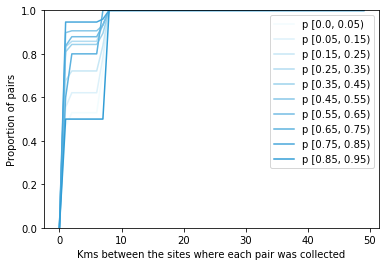

In [4]:
dicton_final={}
for uu in [ "all"]:
    dicton_final[uu]={}
    
for kk in [750]:
    print(kk)
    uu="all"
    df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica[uu],
                 "Similitud_genetica_4":distancias_genetica4[uu][kk]})
    dicton_final[uu][kk]=final_plot_old(df_pares_abejas)



In [34]:
tasks_sql_dicton={200:tasks_sql_200m, 300:tasks_sql_300m, 500:tasks_sql_500m}

result_pmeth_2("kuringbai", dicton_final, category, tasks_sql_dicton)


76
Deleting k=100


76
Deleting k=100
76    


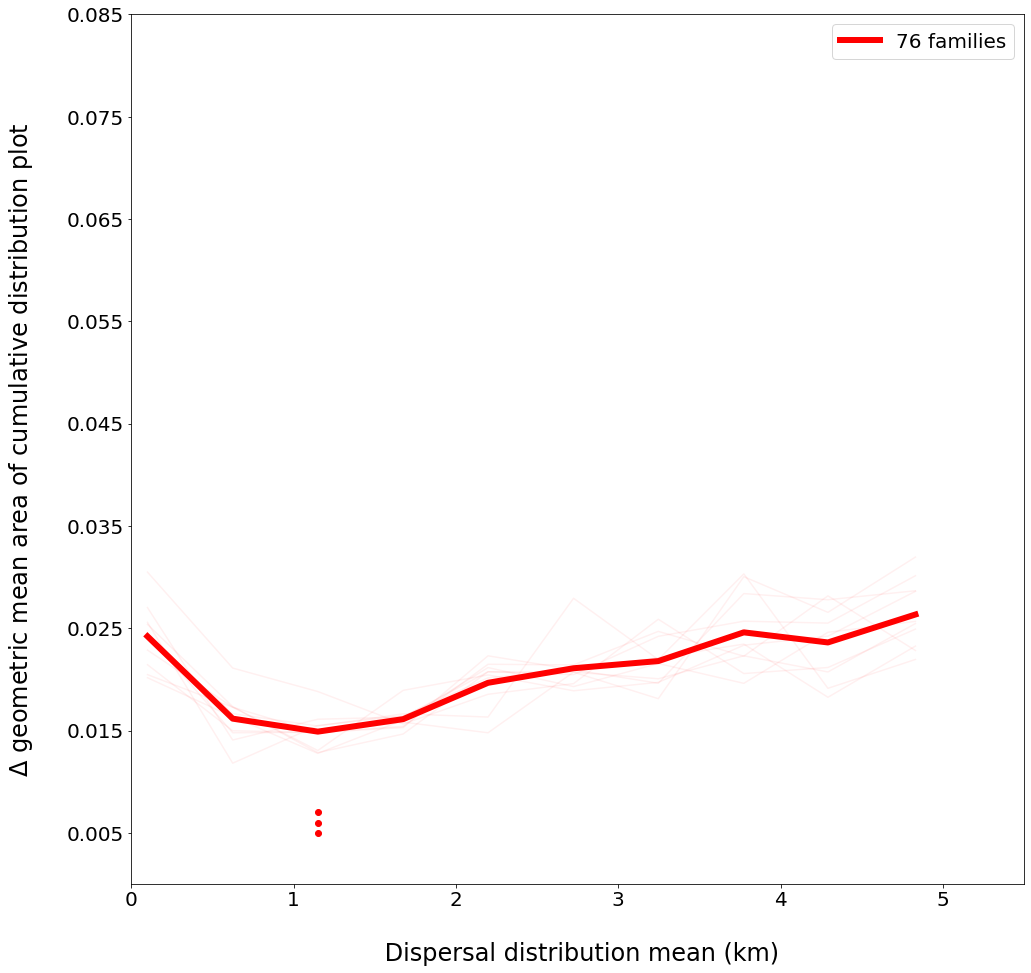

76
Deleting k=100
76        


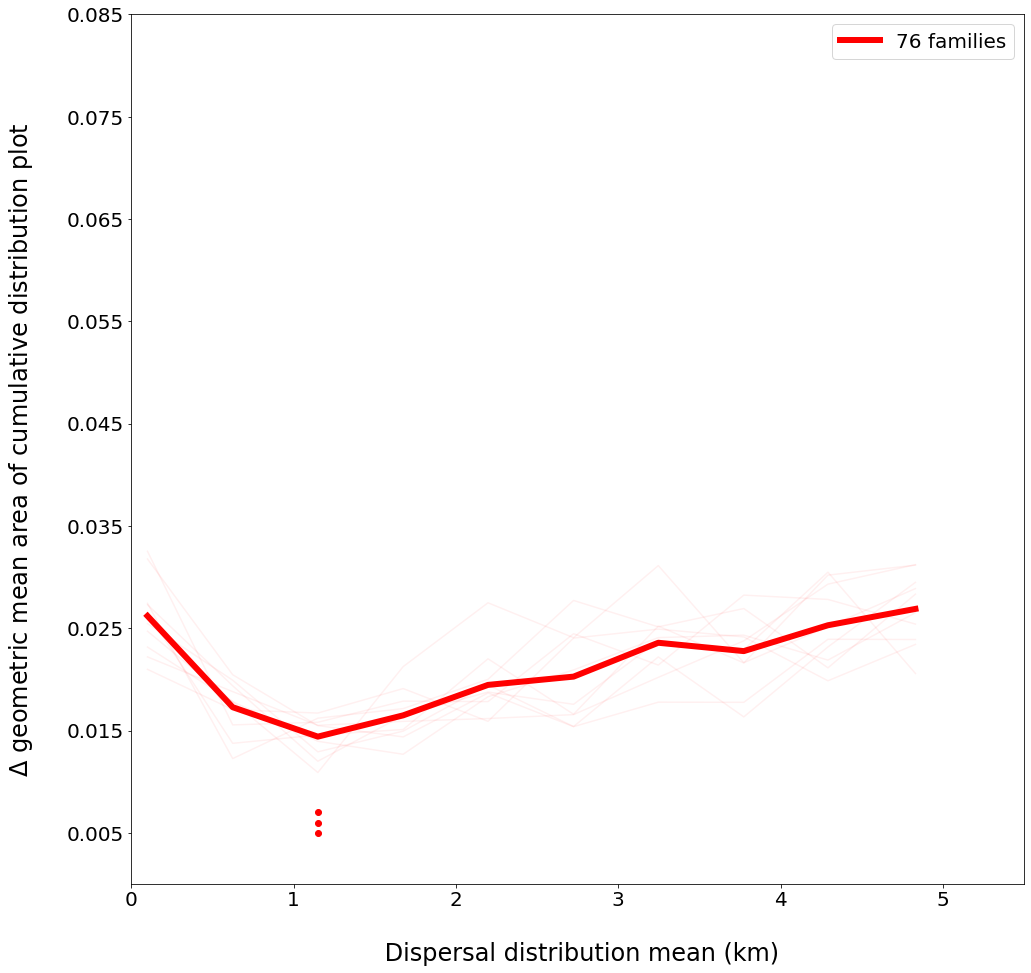

76
Deleting k=100
76    


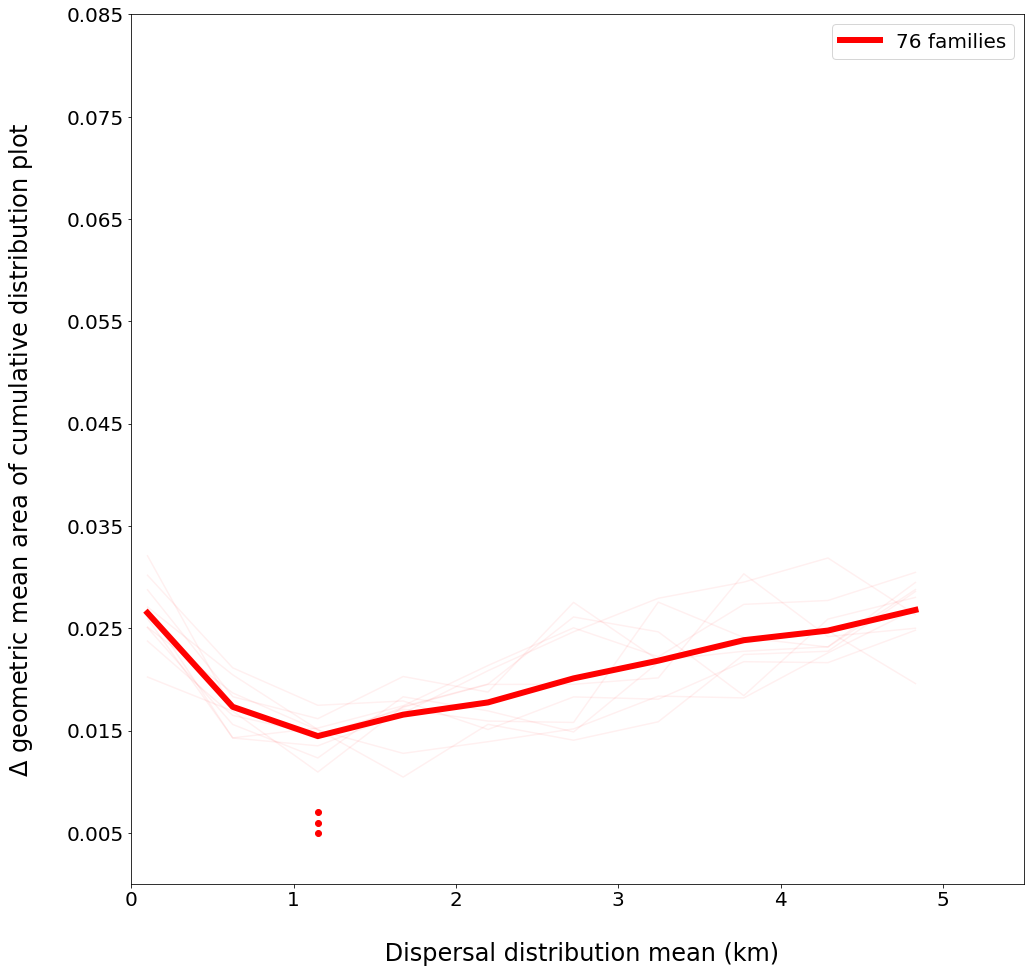

In [5]:
result_pmeth("kuringbai", dicton_final, category, tasks_sql_500m)
result_pmeth("kuringbai", dicton_final, category, tasks_sql_300m)
result_pmeth("kuringbai", dicton_final, category, tasks_sql_200m)


In [36]:
means=set(1/(eval(k["task_params"])["params"]["lambd"]) for k in tasks_sql)

In [39]:
mean=1.1494252873563218
nmam_bias=76

In [40]:
new_tasks=[]
placebos=[]
for k in tasks_sql_500m:
    if (eval(k["task_params"])["N_mam"])==nmam_bias:
        new_tasks.append(k)
        if 1/(eval(k["task_params"])["params"]["lambd"])==mean:
            placebos.append(k["task_id"])

76
76    
760      
76    
7601      
76    
7602      
76    
7603      
76    
7604      
76    
7605      
76    
7606      
76    
7607      
76    
7608      
76    
7609      
76    
761      
76    
7611      
76    
7612      
76    
7613      
76    
7614      
76    
7615      
76    
7616      
76    
7617      
76    
7618      
76    
7619      
76    
762      
76    
7621      
76    
7622      
76    
7623      
76    
7624      
76    
7625      
76    
7626      
76    
7627      
76    
7628      
76    
7629      
76    
763      
76    
7631      
76    
7632      
76    
7633      
76    
7634      
76    
7635      
76    
7636      
76    
7637      
76    
7638      
76    
7639      
76    
764      
76    
7641      
76    
7642      
76    
7643      
76    
7644      
76    
7645      
76    
7646      
76    
7647      
76    
7648      
76    
7649      
76    
765      
76    
7651      
76    
7652      
76    
7653      
76    
7654      
76    
7655  

<Figure size 1152x1152 with 0 Axes>

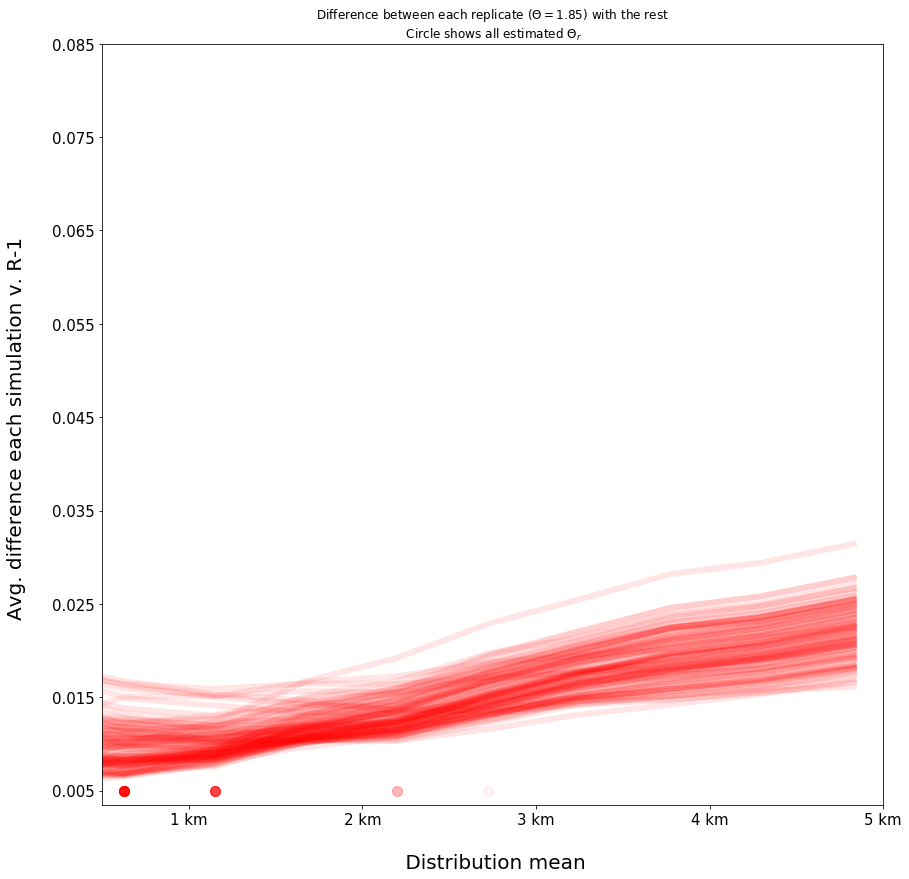

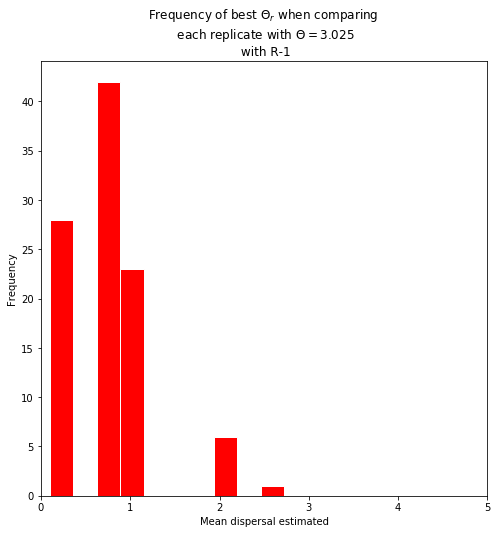

Mean :0.7139839043633555
Std :0.5701102701623741


In [41]:
make_bias_test1(placebos, new_tasks, "all", nmam_bias, "kuringbai")

## QL

In [2]:
category="all"

with open("all_families_QL.pkl", "rb") as fil:
    distancias_genetica4, distancias_fisica = pickle.load( fil)

In [3]:
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where task_params like \"%QL%\""
    cursor.execute(sql)
    tasks_sql=cursor.fetchall()
connection.close()



350


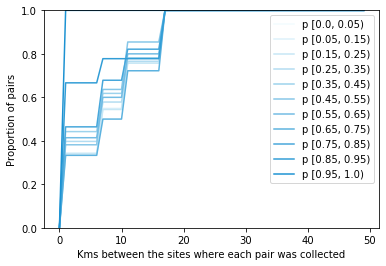

550


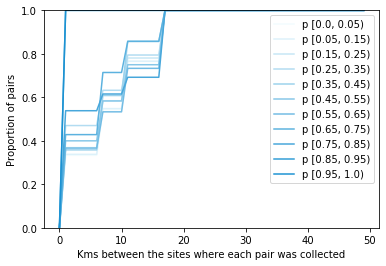

750


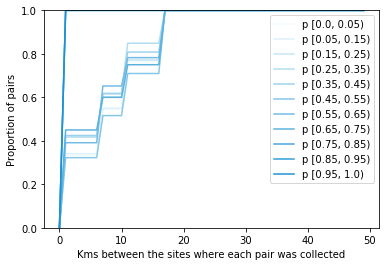

In [4]:
dicton_final={}
for uu in [ "all"]:
    dicton_final[uu]={}
    
for kk in [350, 550, 750]:
    print(kk)
    uu="all"
    df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica[uu],
                 "Similitud_genetica_4":distancias_genetica4[uu][kk]})
    dicton_final[uu][kk]=final_plot_old(df_pares_abejas)



550
350
750
550   
350
750


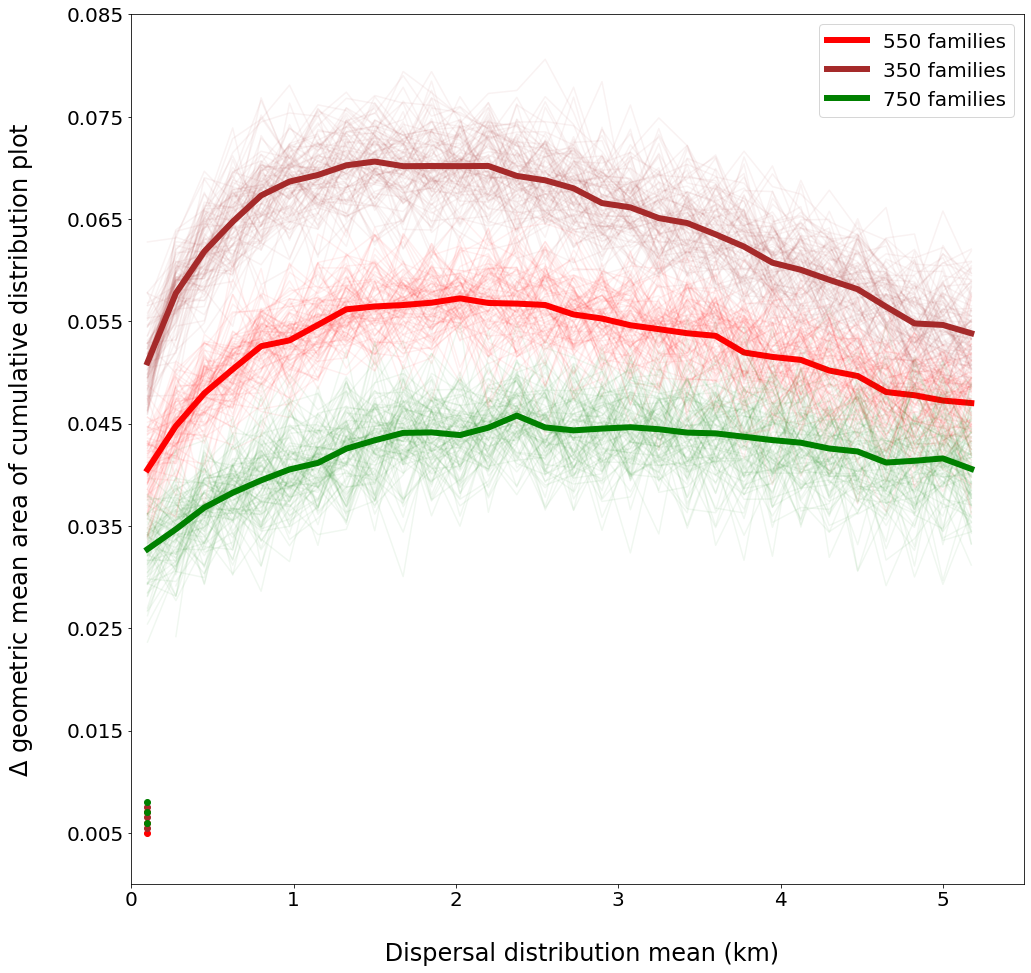

In [5]:
result_pmeth("QL", dicton_final, category, tasks_sql)

In [6]:
means=set(1/(eval(k["task_params"])["params"]["lambd"]) for k in tasks_sql)

In [7]:
mean=1.8500000000000003
nmam_bias=350

In [8]:
new_tasks=[]
placebos=[]
for k in tasks_sql:
    if (eval(k["task_params"])["N_mam"])==nmam_bias:
        new_tasks.append(k)
        if 1/(eval(k["task_params"])["params"]["lambd"])==mean:
            placebos.append(k["task_id"])

350
350   
350      
350   
3501      
350   
3502      
350   
3503      
350   
3504      
350   
3505      
350   
3506      
350   
3507      
350   
3508      
350   
3509      
350   
350      
350   
3501      
350   
3502      
350   
3503      
350   
3504      
350   
3505      
350   
3506      
350   
3507      
350   
3508      
350   
3509      
350   
350      
350   
3501      
350   
3502      
350   
3503      
350   
3504      
350   
3505      
350   
3506      
350   
3507      
350   
3508      
350   
3509      
350   
350      
350   
3501      
350   
3502      
350   
3503      
350   
3504      
350   
3505      
350   
3506      
350   
3507      
350   
3508      
350   
3509      
350   
350      
350   
3501      
350   
3502      
350   
3503      
350   
3504      
350   
3505      
350   
3506      
350   
3507      
350   
3508      
350       
3509      
350   
350      
350   
3501      
350   
3502      
350   
3503      
350   
3504      
350   
3

<Figure size 1152x1152 with 0 Axes>

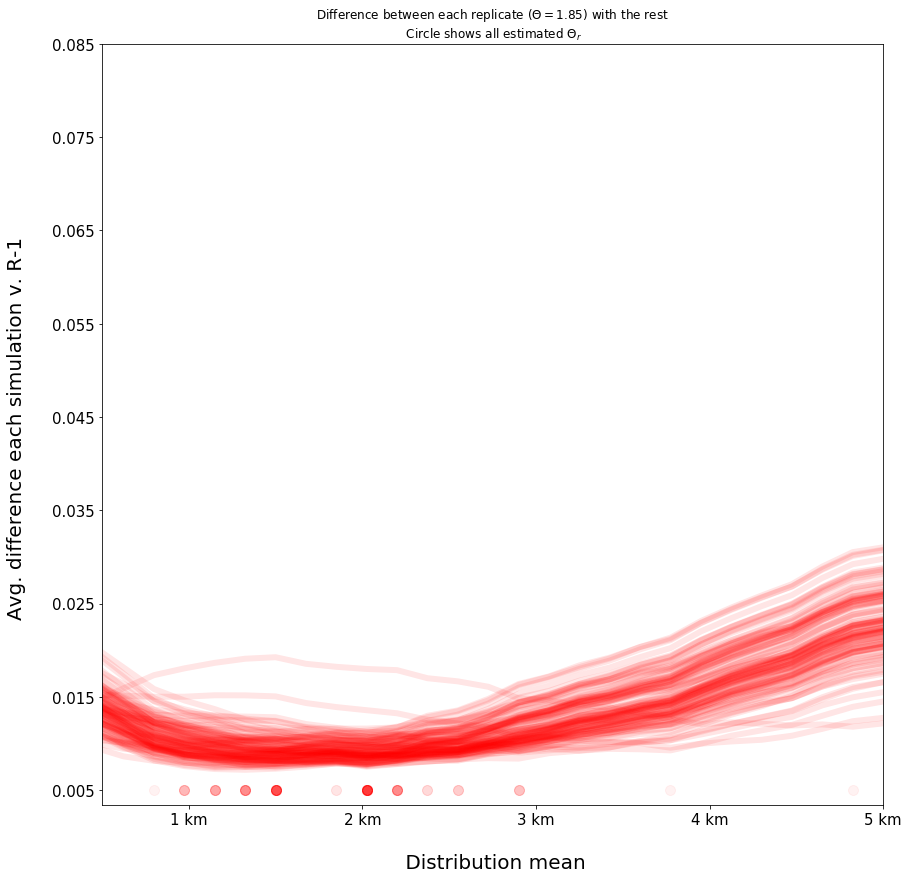

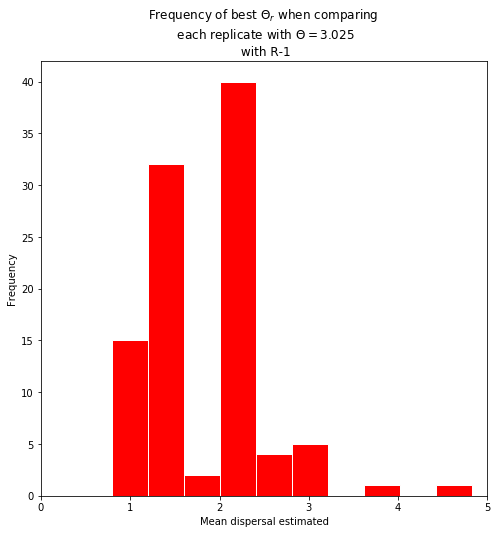

Mean :1.829
Std :0.617866490433006


In [9]:
make_bias_test1(placebos, new_tasks, "all", nmam_bias, "QL")

## Syd 2018 -min catch

In [70]:
with open("all_families_all.pkl", "rb") as fil:
        distancias_genetica4, distancias_fisica=pickle.load(fil)
        
        
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where  task_completed>0 and batchname=\"cathcmentSYD2018\" "
    cursor.execute(sql)
    tasks_sql=cursor.fetchall()
connection.close()


In [73]:
tasks_sql_dicton={ 200:[],  300:[], 500:[]}
for t in tasks_sql:
    catch=eval(t["task_params"]).get("min_dist", np.nan)
    #if np.isnan(catch): catch=1.0
    if (eval(t["task_params"]).get("N_mam", np.nan)==600) and (eval(t["task_params"]).get("bootstrap", np.nan)<=600):
        if not np.isnan(catch): tasks_sql_dicton[int(500*catch)].append(t)

In [74]:
for key in tasks_sql_dicton:
    print(len(tasks_sql_dicton[key]))

1054
1077
1082


In [43]:
with open("all_families_all.pkl", "rb") as fil:
        distancias_genetica4, distancias_fisica=pickle.load(fil)

In [44]:
distancias_genetica4["all"].keys()

dict_keys([100, 300, 450, 600, 750, 900, 1500])

100


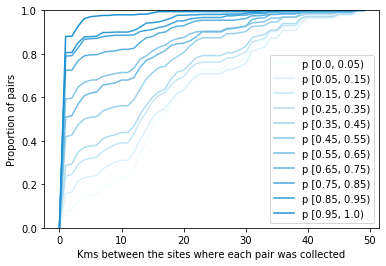

300


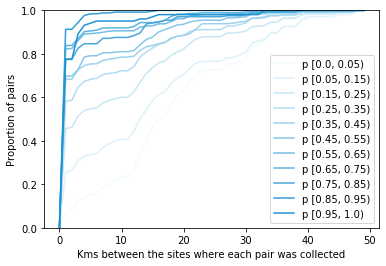

450


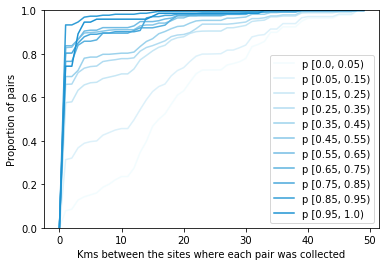

600


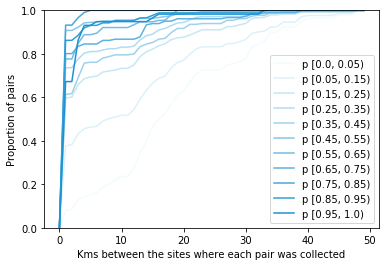

750


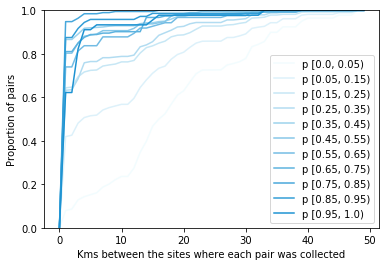

900


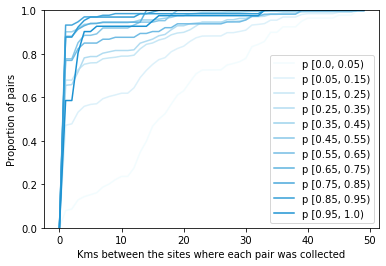

1500


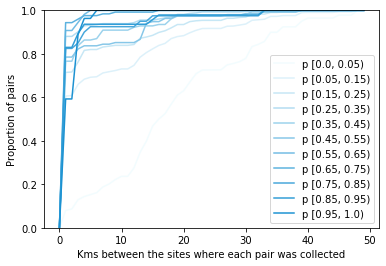

In [45]:
dicton_final={}
for uu in [ "all"]:
    dicton_final[uu]={}
    
for kk in distancias_genetica4["all"].keys():
    print(kk)
    uu="all"
    df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica[uu],
                 "Similitud_genetica_4":distancias_genetica4[uu][kk]})
    dicton_final[uu][kk]=final_plot_old(df_pares_abejas)



600


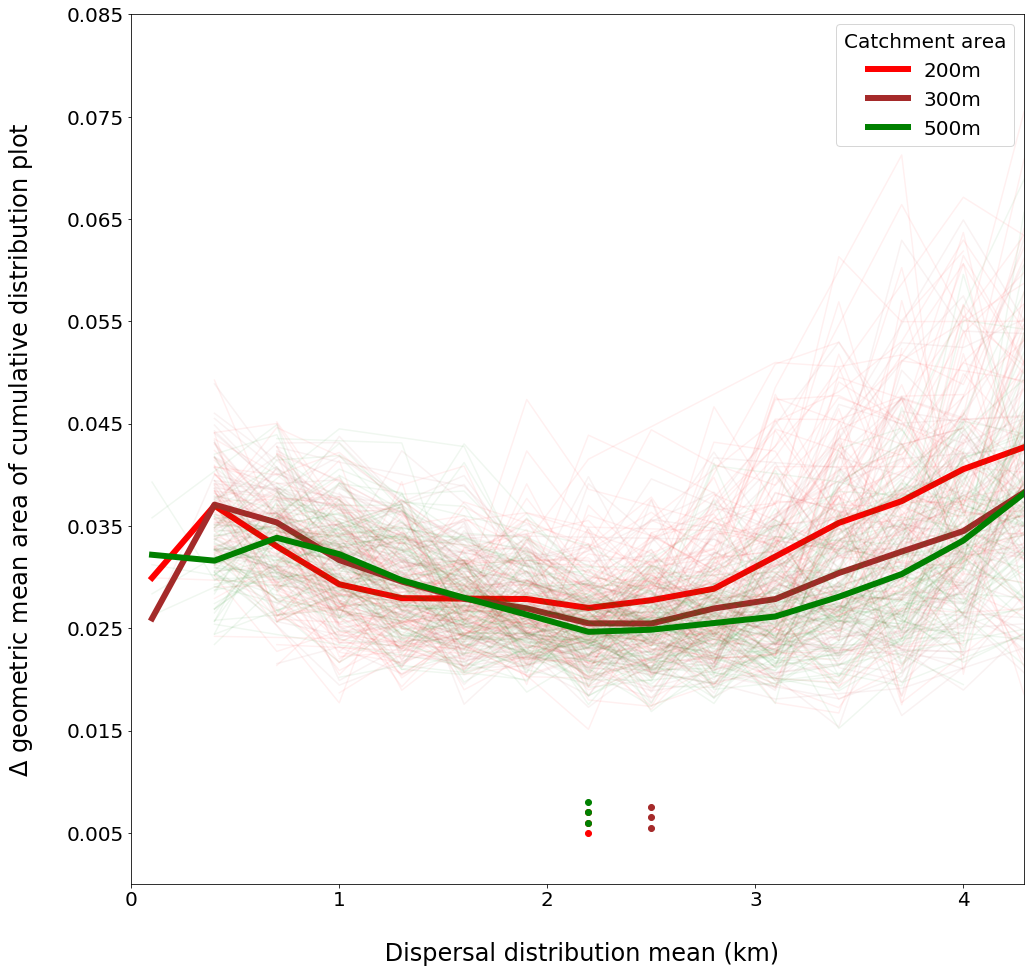

In [77]:

result_pmeth_2("sydney_catchment", dicton_final, "all", tasks_sql_dicton)


## Syd 2018

In [10]:
with open("all_families_all.pkl", "rb") as fil:
        distancias_genetica4, distancias_fisica=pickle.load(fil)

In [3]:
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where ((task_params not like \"%\\\"year\\\":2017%\") AND (task_params not like \"%\\\"year\\\":\\\"QL\\\"%\")) and task_completed>0 and task_id>118341 "
    sql+="and (task_params not like \"%\\\"urban\\\":False%\") and  (task_params not like \"%\\\"rural\\\":False%\") and (task_params not like \"%\\\"N_mam\\\":475%\") "
    cursor.execute(sql)
    tasks_sql=cursor.fetchall()
connection.close()


100


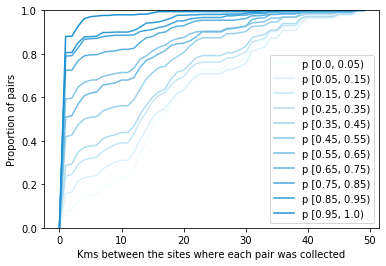

300


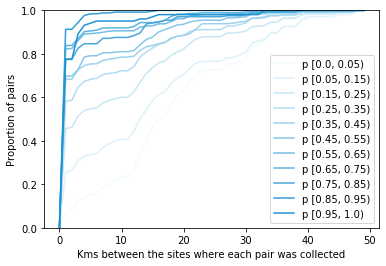

450


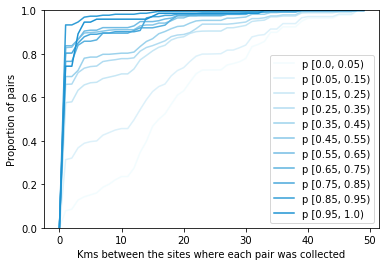

600


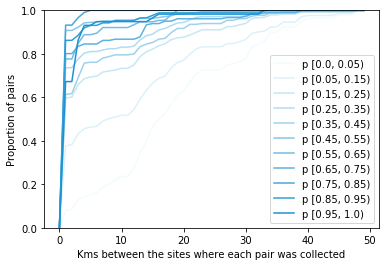

750


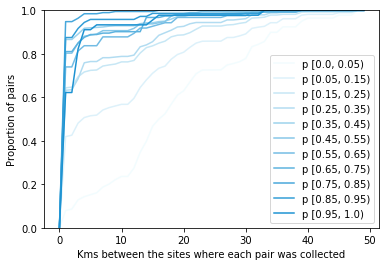

900


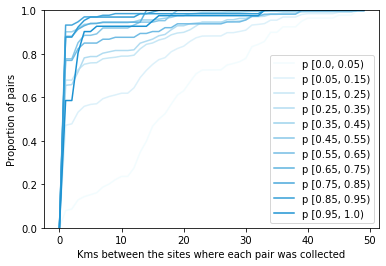

1500


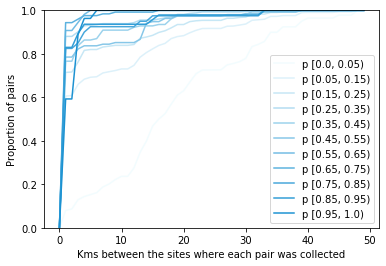

In [12]:
dicton_final={}
for uu in [ "all"]:
    dicton_final[uu]={}
    
for kk in distancias_genetica4["all"].keys():
    print(kk)
    uu="all"
    df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica[uu],
                 "Similitud_genetica_4":distancias_genetica4[uu][kk]})
    dicton_final[uu][kk]=final_plot_old(df_pares_abejas)



In [7]:
tasks_sql=pd.DataFrame(tasks_sql)

In [8]:
tasks_sql["N_mam"]=[eval(i).get("N_mam", np.nan) for i in tasks_sql["task_params"]]

In [9]:
tasks_sql["min_dist"]=[eval(i).get("min_dist", np.nan) for i in tasks_sql["task_params"]]

In [11]:
len(tasks_sql)

12351

In [10]:
tasks_sql["min_dist"].value_counts()

0.4    1104
0.6    1077
1.0    1077
0.2     100
Name: min_dist, dtype: int64

In [13]:
result_pmeth("Syd2018", dicton_final, category, tasks_sql)

600
450
750
600   
450
750


In [14]:
nmam_bias=750
mean=2.025

In [15]:
new_tasks=[]
placebos=[]
for k in tasks_sql:
    if (eval(k["task_params"])["N_mam"])==nmam_bias:
        new_tasks.append(k)
        if 1/(eval(k["task_params"])["params"]["lambd"])==mean:
            placebos.append(k["task_id"])

750
750   
750      
750   
7501      
750   
7502      
750   
7503      
750   
7504      
750   
7505      
750   
7506      
750   
7507      
750   
7508      
750   
7509      
750   
750      
750   
7501      
750   
7502      
750   
7503      
750   
7504      
750   
7505      
750   
7506      
750   
7507      
750   
7508      
750   
7509      
750   
750      
750   
7501      
750   
7502      
750   
7503      
750   
7504      
750   
7505      
750   
7506      
750   
7507      
750   
7508      
750   
7509      
750   
750      
750   
7501      
750   
7502      
750   
7503      
750   
7504      
750   
7505      
750   
7506      
750   
7507      
750   
7508      
750   
7509      
750   
750      
750   
7501      
750   
7502      
750   
7503      
750   
7504      
750   
7505      
750   
7506      
750   
7507      
750   
7508      
750   
7509      
750   
750      
750   
7501      
750   
7502      
750   
7503      
750   
7504      
750   
7505 

<Figure size 1152x1152 with 0 Axes>

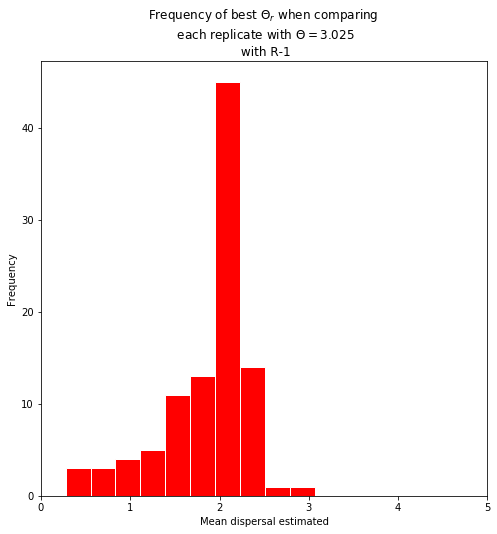

Mean :1.84475
Std :0.4921546377918225


In [16]:
make_bias_test1(placebos, new_tasks, "all", nmam_bias, "Syd2018")

## Rural Syd 2018

In [17]:
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where ((task_params not like \"%\\\"year\\\":2017%\") AND (task_params not like \"%\\\"year\\\":\\\"QL\\\"%\")) and task_completed>0 and task_id>0 "
    sql+="and (task_params like \"%\\\"urban\\\":False%\") and  (task_params like \"%\\\"rural\\\":True%\")  "
    cursor.execute(sql)
    tasks_sql=cursor.fetchall()
connection.close()


In [18]:
with open("all_families_all.pkl", "rb") as fil:
        distancias_genetica4, distancias_fisica=pickle.load(fil)

100


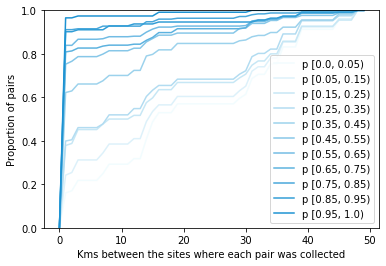

300


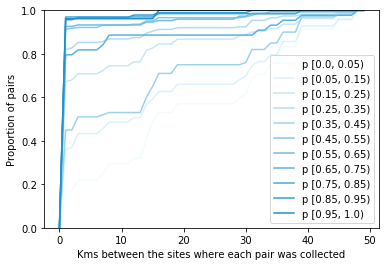

450


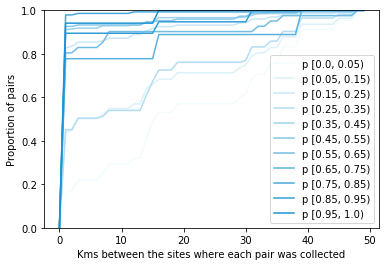

600


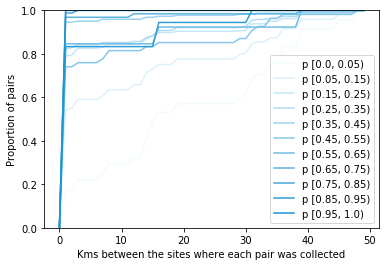

750


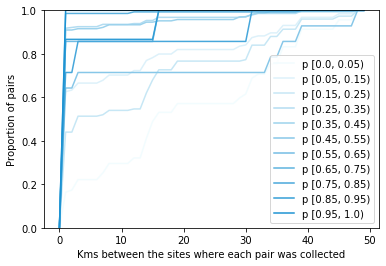

900


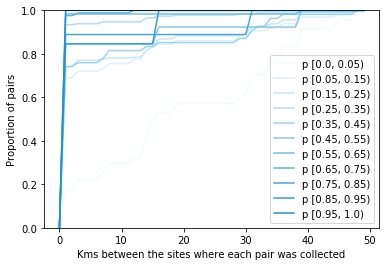

1500


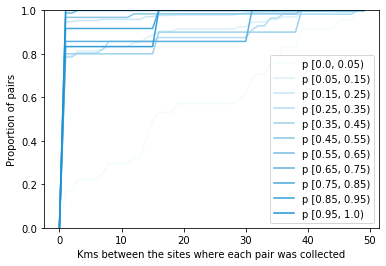

In [19]:
dicton_final={}
for uu in [ "rural"]:
    dicton_final[uu]={}
    
for kk in distancias_genetica4["rural"].keys():
    print(kk)
    uu="rural"
    df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica[uu],
                 "Similitud_genetica_4":distancias_genetica4[uu][kk]})
    dicton_final[uu][kk]=final_plot_old(df_pares_abejas)



300
300   


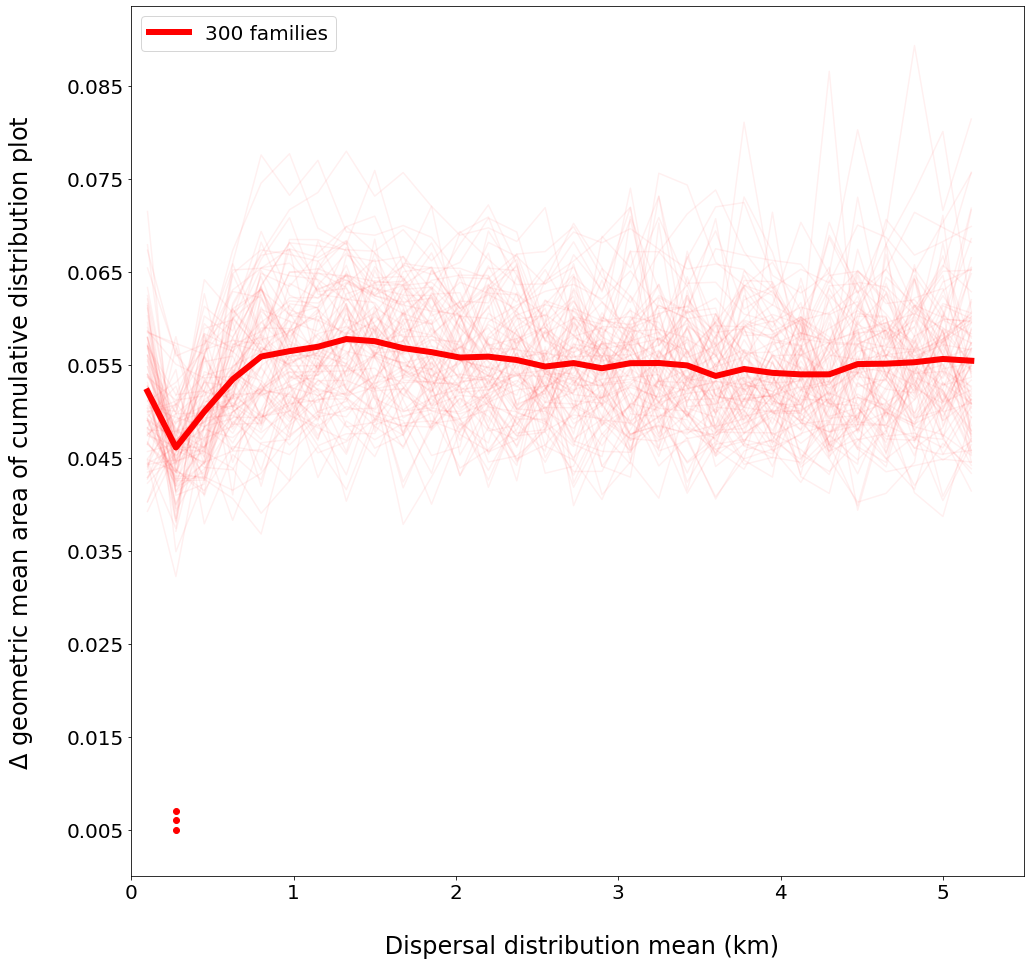

In [20]:
result_pmeth("Syd2018_rural", dicton_final, "rural", tasks_sql)

In [21]:
nmam_bias=300
mean=2.025

In [22]:
new_tasks=[]
placebos=[]
for k in tasks_sql:
    if (eval(k["task_params"])["N_mam"])==nmam_bias:
        new_tasks.append(k)
        if 1/(eval(k["task_params"])["params"]["lambd"])==mean:
            placebos.append(k["task_id"])

300
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005 

<Figure size 1152x1152 with 0 Axes>

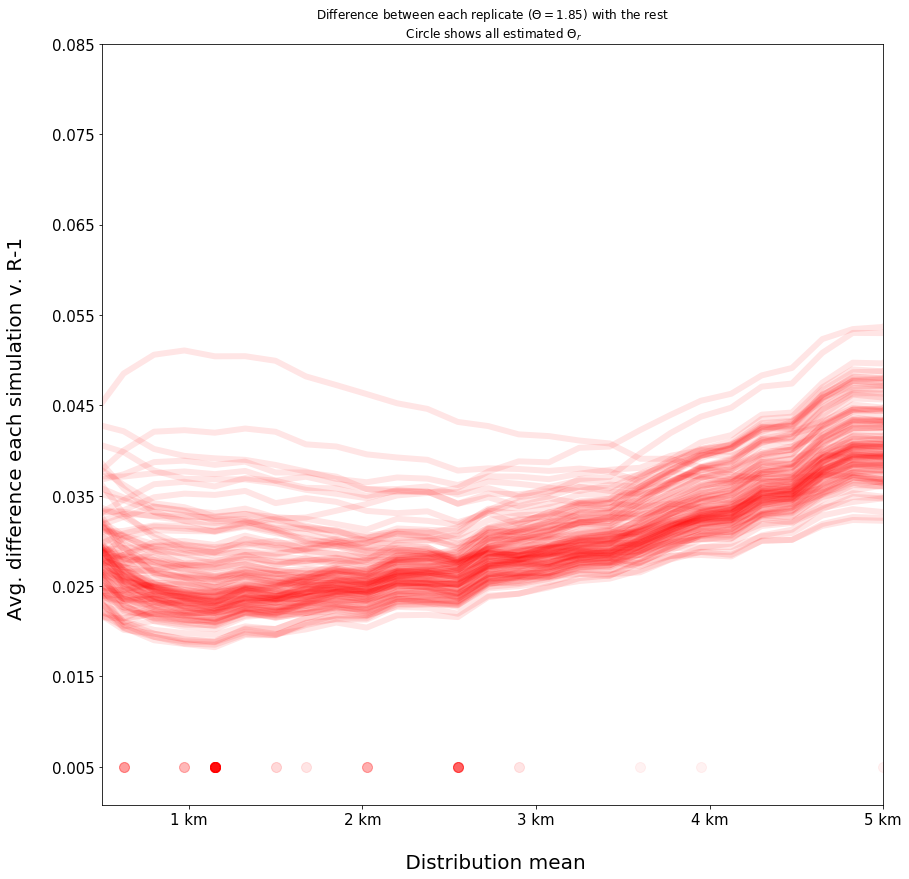

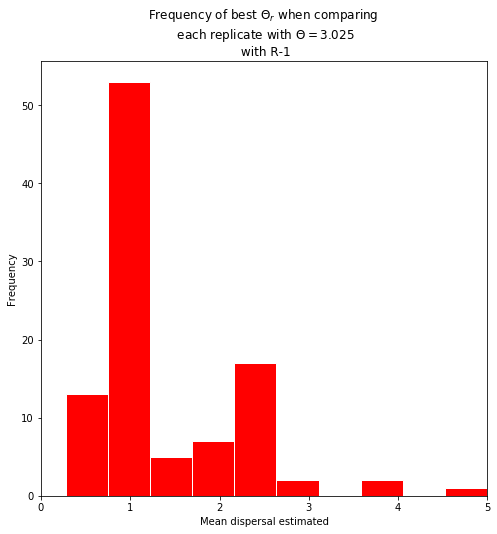

Mean :1.5087500000000003
Std :0.8149722004461256


In [23]:
make_bias_test1(placebos, new_tasks, "rural", nmam_bias, "Rural")


## Urban Syd 2018

In [24]:
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where ((task_params not like \"%\\\"year\\\":2017%\") AND (task_params not like \"%\\\"year\\\":\\\"QL\\\"%\")) and task_completed>0 and task_id>0 "
    sql+="and (task_params like \"%\\\"urban\\\":True%\") and  (task_params like \"%\\\"rural\\\":False%\")  "
    cursor.execute(sql)
    tasks_sql=cursor.fetchall()
connection.close()


In [25]:
with open("all_families_all.pkl", "rb") as fil:
        distancias_genetica4, distancias_fisica=pickle.load(fil)

In [36]:
kk

1500

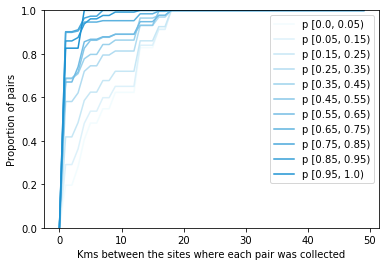

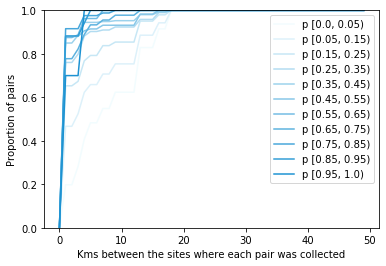

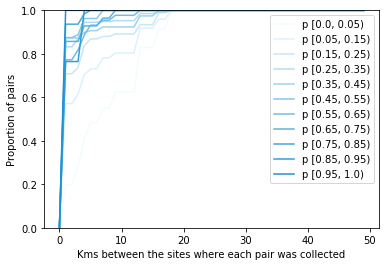

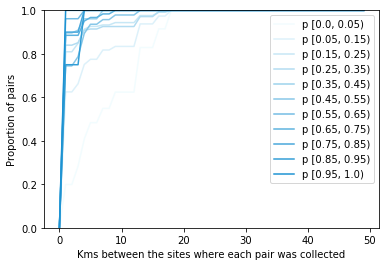

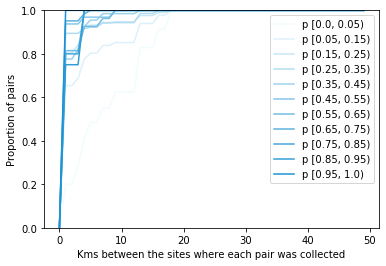

In [38]:
dicton_final={}
for uu in [ "urban"]:
    dicton_final[uu]={}
    
for kk in distancias_genetica4["urban"].keys():
    if kk<1500:
        uu="urban"
        df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica[uu],
                     "Similitud_genetica_4":distancias_genetica4[uu][kk]})
        dicton_final[uu][kk]=final_plot_old(df_pares_abejas)



In [39]:
result_pmeth("Syd2018_urban", dicton_final, "urban", tasks_sql)

300
300   


In [40]:
nmam_bias=300
mean=2.025

In [41]:
new_tasks=[]
placebos=[]
for k in tasks_sql:
    if (eval(k["task_params"])["N_mam"])==nmam_bias:
        new_tasks.append(k)
        if 1/(eval(k["task_params"])["params"]["lambd"])==mean:
            placebos.append(k["task_id"])

300
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300       
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3005      
300   
3006      
300   
3007      
300   
3008      
300   
3009      
300   
300      
300   
3001      
300   
3002      
300   
3003      
300   
3004      
300   
3

<Figure size 1152x1152 with 0 Axes>

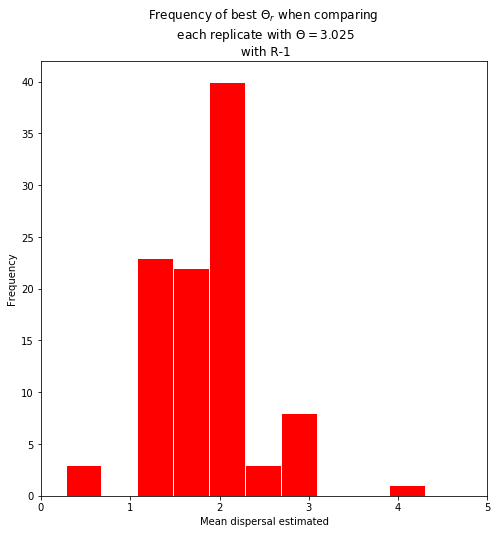

Mean :1.8219999999999998
Std :0.5685318812520542


In [42]:
make_bias_test1(placebos, new_tasks, "urban", nmam_bias, "Urban")


## Syd 2017

In [43]:
with open("2017-s.pkl", "rb") as fil:
    dg42017, df2017=pickle.load( fil)

In [44]:
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where task_params like \"%2017%\""
    cursor.execute(sql)
    tasks_sql=cursor.fetchall()
connection.close()



201


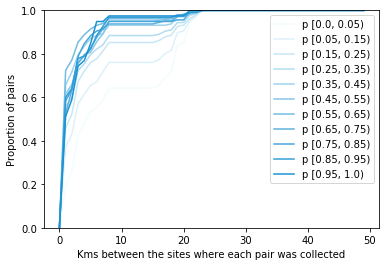

380


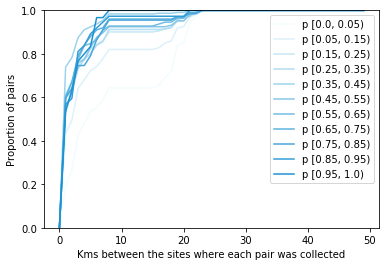

475


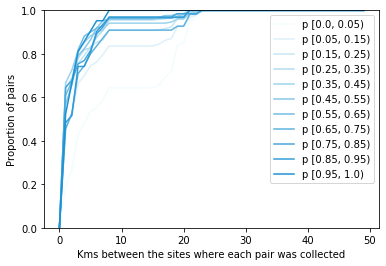

570


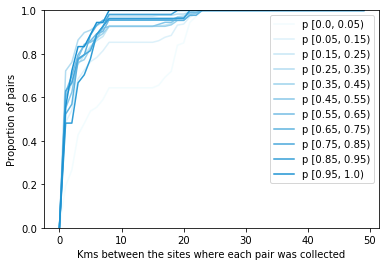

In [45]:
dicton_final={}
for uu in [ "all"]:
    dicton_final[uu]={}
    
for kk in dg42017["all"].keys():
    print(kk)
    uu="all"
    df_pares_abejas=pd.DataFrame({"Distancia":df2017[uu],
                 "Similitud_genetica_4":dg42017[uu][kk]})
    dicton_final[uu][kk]=final_plot_old(df_pares_abejas)



In [46]:
result_pmeth("2017", dicton_final, "all", tasks_sql)

201
570
475
380
201   
570
475
380


In [47]:
nmam_bias=475
mean=2.3

In [48]:
new_tasks=[]
placebos=[]
for k in tasks_sql:
    if (eval(k["task_params"])["N_mam"])==nmam_bias:
        new_tasks.append(k)
        if 1/(eval(k["task_params"])["params"]["lambd"])==mean:
            placebos.append(k["task_id"])

475
475   
475      
475   
4751      
475   
4752      
475   
4753      
475   
4754      
475   
4755      
475   
4756      
475   
4757      
475   
4758      
475   
4759      
475   
475      
475   
4751      
475   
4752      
475   
4753      
475   
4754      
475   
4755      
475   
4756      
475   
4757      
475   
4758      
475   
4759      
475   
475      
475   
4751      
475       
4752      
475   
4753      
475   
4754      
475   
4755      
475   
4756      
475   
4757      
475   
4758      
475   
4759      
475   
475      
475   
4751      
475       
4752      
475   
4753      
475   
4754      
475   
4755      
475   
4756      
475   
4757      
475   
4758      
475   
4759      
475   
475      
475   
4751      
475   
4752      
475   
4753      
475   
4754      
475   
4755      
475   
4756      
475   
4757      
475   
4758      
475   
4759      
475   
475      
475   
4751      
475   
4752      
475   
4753      
475   
4754      
475 

<Figure size 1152x1152 with 0 Axes>

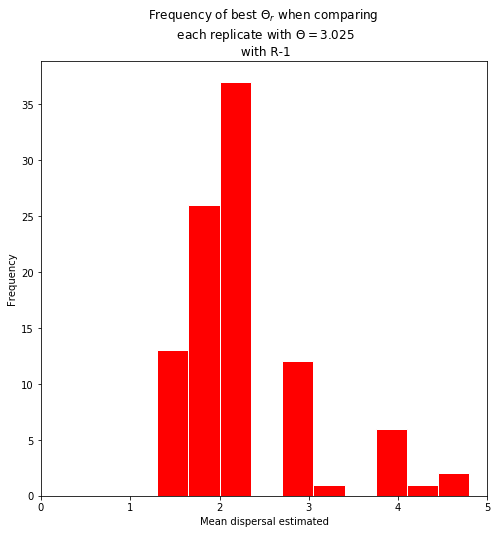

Mean :2.2693877551020414
Std :0.7382284590892213


In [49]:
make_bias_test1(placebos, new_tasks, "all", nmam_bias, "syd2017")

In [50]:
df_tasks=pd.DataFrame(tasks_sql)
df_tasks["N_mam"]=[eval(i)["N_mam"] for i in df_tasks["task_params"]]
df_tasks["bootstrap"]=[eval(i)["bootstrap"] for i in df_tasks["task_params"]]

In [51]:
df_tasks["N_mam"].value_counts()

475    1200
570    1200
201    1200
380    1200
Name: N_mam, dtype: int64

In [52]:
df_tasks[(df_tasks.N_mam==750) & (df_tasks.bootstrap==5)]

Empty DataFrame
Columns: [task_completed, task_id, task_name, task_params, task_responsible, N_mam, bootstrap]
Index: []

In [53]:
list(df_tasks[(df_tasks.N_mam==750) & (df_tasks.bootstrap==5)]["task_params"])

[]

In [54]:
plt.hist(listfams)

NameError: name 'listfams' is not defined

In [ ]:
len(listfams)

In [ ]:
nl=[]
i=0
for s in listfams:
    nl.append({"Familia":"F"+str(i), "Miembros":s})
    i+=1

In [ ]:
df=pd.DataFrame(nl)

In [ ]:
len(set(df.sample(n=2118, replace=True, weights="Miembros")["Familia"]))

In [ ]:
plt.hist(df.sample(n=2118, replace=True, weights="Miembros").groupby("Familia").count()["Miembros"], bins=50)

